# Calculating Elder Impulse for long view

In [1]:
# IMPORTING PACKAGES

import pandas as pd
import requests
from datetime import datetime, timedelta
import talib
import matplotlib.pyplot as plt


/var/folders/sk/ckljlph97j1grnldzlf4khtc0000gn/T/ipykernel_31002/172189558.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Getting historical data from binance API

In [2]:
#The variable days_back represents the number of days in the past from which I intend to retrieve the data.
#The variable symbol is a coin pair. For example if you want bitcoin historical data, the symbol to use is BTCUSDT. 

API_URL = 'https://api.binance.com/api/v3/klines' # Binance API endpoint for candlestick data

def get_historical_data(symbol, days_back, interval):
    # Calculate the start time in milliseconds
    start_time = int((datetime.now() - timedelta(days=days_back)).timestamp() * 1000)

    # Calculate the current time in milliseconds
    end_time = int(datetime.now().timestamp() * 1000)

    # Make an API request to retrieve historical data
    hist_json = requests.get(API_URL, params={
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'endTime': end_time,
        'limit': 1000  # Maximum number of data points per request
    }).json()
    
    # Making a df from response
    # Extract only the relevant elements for each row
    df = pd.DataFrame(hist_json, columns=[
        'Time', 'Open Price', 'High Price', 'Low Price',
        'Close Price', 'Volume', 'Kline Close Time', 'Quote Asset Volume',
        'Number of Trades', 'Taker Buy Base Asset Volume',
        'Taker Buy Quote Asset Volume', 'Unused Field'
    ])

    # Select only the relevant columns (Open Time, Open Price, High Price, Low Price, Close Price, Volume)
    df = df[['Time', 'Open Price', 'High Price', 'Low Price', 'Close Price', 'Volume']]
    df['dateTime'] = pd.to_datetime(df['Time'], unit='ms')
    
    return df


In [3]:
def transform_hist_data(df_name):
    df_name['Open Price'] = pd.to_numeric(df_name['Open Price'], errors='coerce').astype(float)
    df_name['High Price'] = pd.to_numeric(df_name['High Price'], errors='coerce').astype(float)
    df_name['Low Price'] = pd.to_numeric(df_name['Low Price'], errors='coerce').astype(float)
    df_name['Close Price'] = pd.to_numeric(df_name['Close Price'], errors='coerce').astype(float)
    df_name['Volume'] = pd.to_numeric(df_name['Volume'], errors='coerce').astype(float)
    return df_name


## Creating a table for calculating elder impulse

Elder Impulse
https://school.stockcharts.com/doku.php?id=chart_analysis:elder_impulse_system
MACD-histogram
https://www.investopedia.com/ask/answers/122414/what-moving-average-convergence-divergence-macd-formula-and-how-it-calculated.asp

In [4]:
df_long = get_historical_data('BTCUSDT', 360, '1w')


In [5]:
df_long.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         51 non-null     int64         
 1   Open Price   51 non-null     object        
 2   High Price   51 non-null     object        
 3   Low Price    51 non-null     object        
 4   Close Price  51 non-null     object        
 5   Volume       51 non-null     object        
 6   dateTime     51 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 2.9+ KB


In [6]:
df_long.shape

(51, 7)

In [7]:
df_long = transform_hist_data(df_long)

In [8]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         51 non-null     int64         
 1   Open Price   51 non-null     float64       
 2   High Price   51 non-null     float64       
 3   Low Price    51 non-null     float64       
 4   Close Price  51 non-null     float64       
 5   Volume       51 non-null     float64       
 6   dateTime     51 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 2.9 KB


In [9]:
#Function for calculating EMA-s
def calculate_emas(df_name):
    df_name['13EMA'] = df_name['Close Price'].ewm(span=13, adjust=False).mean()
    df_name['12EMA'] = df_name['Close Price'].ewm(span=12, adjust=False).mean()
    df_name['26EMA'] = df_name['Close Price'].ewm(span=26, adjust=False).mean()
    return df_name
    

In [10]:
df_long = calculate_emas(df_long)

In [11]:
def calculate_macd(df_name):
    # Calculate MACD Line (12EMA - 26EMA)
    df_name['MACD'] = df_name['12EMA'] - df_name['26EMA']

    # Calculate Signal Line (9-period EMA of MACD)
    df_name['Signal'] = df_name['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate MACD Histogram
    df_name['Histogram'] = df_name['MACD'] - df_name['Signal']
    return df_name
    

In [12]:
df_long = calculate_macd(df_long)

In [13]:
df_long.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,13EMA,12EMA,26EMA,MACD,Signal,Histogram
46,1705881600000,41580.32,42842.68,38555.00,42031.06,274603.16207,2024-01-22,39772.699885,40097.987112,36233.339608,3864.647504,3577.918553,286.728951
47,1706486400000,42031.05,43882.36,41804.88,42582.88,203036.61925,2024-01-29,40174.154188,40480.278326,36703.675933,3776.602393,3617.655321,158.947071
48,1707091200000,42582.88,48592.66,42258.10,48299.99,262240.48357,2024-02-05,41334.987875,41683.310891,37562.662160,4120.648731,3718.254003,402.394728
49,1707696000000,48300.00,52816.62,47710.01,52137.67,310862.30170,2024-02-12,42878.228179,43291.673831,38642.292371,4649.381460,3904.479495,744.901966
50,1708300800000,52137.68,52985.00,50521.00,51720.66,214060.92979,2024-02-19,44141.432725,44588.440934,39611.060343,4977.380591,4119.059714,858.320877


## Calculating elder impulse

Kalkuleerin elder impulse iga rea kohta tabelis

In [40]:
for i in range(1, len(df_long)):
    ema_comparison = 0
    macd_comparison = 0
    first_row_ema = df_long.iloc[i-1]['13EMA']
    second_row_ema = df_long.iloc[i]['13EMA']
    if second_row_ema > first_row_ema:
        ema_comparison = 1
    elif second_row_ema < first_row_ema:
        ema_comparison = -1
    first_row_macd = df_long.iloc[i-1]['Histogram']
    second_row_macd = df_long.iloc[i]['Histogram']
    if second_row_macd > first_row_macd:
        macd_comparison = 1
    elif second_row_macd < first_row_macd:
        macd_comparison = -1
    if ema_comparison == 1 and macd_comparison == 1:
          df_long.at[i, 'elder_impulse'] = 1
    elif ema_comparison == -1 and macd_comparison == -1:
        df_long.at[i, 'elder_impulse'] = -1
    else:
        df_long.at[i, 'elder_impulse'] = 0


In [43]:
df_long.head(10)


,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,13EMA,12EMA,26EMA,MACD,Signal,Histogram,elder_impulse
0,1678060800000,22430.24,22602.19,19549.09,21997.11,2.718624e+06,2023-03-06,21997.110000,21997.110000,21997.110000,0.000000,0.000000,0.000000,NaN
1,1678665600000,21998.05,28390.10,21813.88,27972.87,3.775889e+06,2023-03-13,22850.790000,22916.457692,22439.758889,476.698803,95.339761,381.359043,1.0
2,1679270400000,27972.87,28868.05,26601.80,27968.05,1.437829e+06,2023-03-20,23581.827143,23693.625740,22849.261934,844.363805,245.144570,599.219236,1.0
3,1679875200000,27968.05,29184.68,26508.14,28171.87,5.007957e+05,2023-03-27,24237.547551,24382.586395,23243.529198,1139.057197,423.927095,715.130102,1.0
4,1680480000000,28171.87,28775.00,27200.24,28323.76,3.065324e+05,2023-04-03,24821.292187,24988.920796,23619.842591,1369.078205,612.957317,756.120888,1.0
5,1681084800000,28323.76,31000.00,28170.00,30304.65,3.775737e+05,2023-04-10,25604.629017,25806.725289,24115.013510,1691.711779,828.708209,863.003569,1.0
6,1681689600000,30304.66,30485.00,27125.00,27590.60,4.304218e+05,2023-04-17,25888.339157,26081.167552,24372.464361,1708.703191,1004.707206,703.995985,0.0
7,1682294400000,27590.59,30036.00,26942.82,29233.21,4.446135e+05,2023-04-24,26366.177849,26566.097159,24732.519594,1833.577566,1170.481278,663.096288,0.0
8,1682899200000,29233.20,29820.00,27666.95,28430.10,3.601180e+05,2023-05-01,26661.023871,26852.866827,25006.414439,1846.452389,1305.675500,540.776889,0.0
9,1683504000000,28430.09,28631.01,25811.46,26917.62,3.387657e+05,2023-05-08,26697.680461,26862.828854,25147.985221,1714.843633,1387.509126,327.334506,0.0


if elder_impulse is 1, it means you can go long; 
if it is -1 , you can go short;
if it is 0 you can do both. 
It is best to go long if impulse is 1 or 0 after -1. (This should be considered good metricks for stock screening)

# Creating Medium view and ATR channels

In [18]:
df_medium = get_historical_data('BTCUSDT', 30, '1d')

In [19]:
df_medium.head()


,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime
0,1706313600000,41823.51000000,42200.00000000,41394.34000000,42120.63000000,16224.41667000,2024-01-27
1,1706400000000,42120.63000000,42842.68000000,41620.81000000,42031.06000000,27294.99838000,2024-01-28
2,1706486400000,42031.05000000,43333.00000000,41804.88000000,43302.70000000,31542.74207000,2024-01-29
3,1706572800000,43302.71000000,43882.36000000,42683.99000000,42941.10000000,37619.24546000,2024-01-30
4,1706659200000,42941.10000000,43745.11000000,42276.84000000,42580.00000000,39871.13688000,2024-01-31


In [20]:
df_medium.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         30 non-null     int64         
 1   Open Price   30 non-null     object        
 2   High Price   30 non-null     object        
 3   Low Price    30 non-null     object        
 4   Close Price  30 non-null     object        
 5   Volume       30 non-null     object        
 6   dateTime     30 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.8+ KB


In [21]:
df_medium['Open Price'] = pd.to_numeric(df_medium['Open Price'], errors='coerce').astype(float)
df_medium['High Price'] = pd.to_numeric(df_medium['High Price'], errors='coerce').astype(float)
df_medium['Low Price'] = pd.to_numeric(df_medium['Low Price'], errors='coerce').astype(float)
df_medium['Close Price'] = pd.to_numeric(df_medium['Close Price'], errors='coerce').astype(float)
df_medium['Volume'] = pd.to_numeric(df_medium['Volume'], errors='coerce').astype(float)

In [22]:
df_medium['ATR21'] = talib.ATR(df_medium['High Price'], df_medium['Low Price'], df_medium['Close Price'], timeperiod=21)
df_medium['ATR14'] = talib.ATR(df_medium['High Price'], df_medium['Low Price'], df_medium['Close Price'], timeperiod=14)

In [23]:
df_medium.tail()


,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14
25,1708473600000,52258.82,52366.80,50625.00,51849.39,43079.40049,2024-02-21,1487.445624,1509.633946
26,1708560000000,51849.38,52065.78,50940.78,51288.42,35309.44574,2024-02-22,1470.186309,1482.160093
27,1708646400000,51288.42,51548.54,50521.00,50744.15,30545.79544,2024-02-23,1449.107913,1449.687229
28,1708732800000,50744.15,51698.00,50585.00,51568.22,16560.42110,2024-02-24,1433.102775,1425.638142
29,1708819200000,51568.21,51898.72,51438.88,51720.66,9416.39952,2024-02-25,1386.756928,1356.652560


In [24]:
df_medium['13EMA'] = df_medium['Close Price'].ewm(span=13, adjust=False).mean()

I will choose ATR 21. Now I will create ATR +1, ATR +2, ATR -1 and -2. These are channels. Then we can compare price against these channels to find entry, stop loss and exit.

In [25]:
# Calculate 21-period EMA
df_medium['21EMA'] = df_medium['Close Price'].ewm(span=21, adjust=False).mean()
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA
25,1708473600000,52258.82,52366.80,50625.00,51849.39,43079.40049,2024-02-21,1487.445624,1509.633946,50284.289113,48771.278418
26,1708560000000,51849.38,52065.78,50940.78,51288.42,35309.44574,2024-02-22,1470.186309,1482.160093,50427.736383,49000.109471
27,1708646400000,51288.42,51548.54,50521.00,50744.15,30545.79544,2024-02-23,1449.107913,1449.687229,50472.938328,49158.658610
28,1708732800000,50744.15,51698.00,50585.00,51568.22,16560.42110,2024-02-24,1433.102775,1425.638142,50629.407138,49377.709646
29,1708819200000,51568.21,51898.72,51438.88,51720.66,9416.39952,2024-02-25,1386.756928,1356.652560,50785.300404,49590.705132


In [26]:
df_medium['ATR+1'] = df_medium['21EMA'] + df_medium['ATR21'] 

In [27]:
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA,ATR+1
25,1708473600000,52258.82,52366.80,50625.00,51849.39,43079.40049,2024-02-21,1487.445624,1509.633946,50284.289113,48771.278418,50258.724043
26,1708560000000,51849.38,52065.78,50940.78,51288.42,35309.44574,2024-02-22,1470.186309,1482.160093,50427.736383,49000.109471,50470.295780
27,1708646400000,51288.42,51548.54,50521.00,50744.15,30545.79544,2024-02-23,1449.107913,1449.687229,50472.938328,49158.658610,50607.766523
28,1708732800000,50744.15,51698.00,50585.00,51568.22,16560.42110,2024-02-24,1433.102775,1425.638142,50629.407138,49377.709646,50810.812420
29,1708819200000,51568.21,51898.72,51438.88,51720.66,9416.39952,2024-02-25,1386.756928,1356.652560,50785.300404,49590.705132,50977.462060


In [28]:
df_medium['ATR+2'] = df_medium['21EMA'] + 2 * df_medium['ATR21'] 
df_medium['ATR+3'] = df_medium['21EMA'] + 3 * df_medium['ATR21'] 

In [29]:
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA,ATR+1,ATR+2,ATR+3
25,1708473600000,52258.82,52366.80,50625.00,51849.39,43079.40049,2024-02-21,1487.445624,1509.633946,50284.289113,48771.278418,50258.724043,51746.169667,53233.615292
26,1708560000000,51849.38,52065.78,50940.78,51288.42,35309.44574,2024-02-22,1470.186309,1482.160093,50427.736383,49000.109471,50470.295780,51940.482089,53410.668398
27,1708646400000,51288.42,51548.54,50521.00,50744.15,30545.79544,2024-02-23,1449.107913,1449.687229,50472.938328,49158.658610,50607.766523,52056.874437,53505.982350
28,1708732800000,50744.15,51698.00,50585.00,51568.22,16560.42110,2024-02-24,1433.102775,1425.638142,50629.407138,49377.709646,50810.812420,52243.915195,53677.017969
29,1708819200000,51568.21,51898.72,51438.88,51720.66,9416.39952,2024-02-25,1386.756928,1356.652560,50785.300404,49590.705132,50977.462060,52364.218989,53750.975917


In [30]:
df_medium['ATR-1'] = df_medium['21EMA'] - df_medium['ATR21'] 

In [31]:
df_medium['ATR-2'] = df_medium['21EMA'] - 2 * df_medium['ATR21'] 
df_medium['ATR-3'] = df_medium['21EMA'] - 3 * df_medium['ATR21'] 

In [32]:
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA,ATR+1,ATR+2,ATR+3,ATR-1,ATR-2,ATR-3
25,1708473600000,52258.82,52366.80,50625.00,51849.39,43079.40049,2024-02-21,1487.445624,1509.633946,50284.289113,48771.278418,50258.724043,51746.169667,53233.615292,47283.832794,45796.387169,44308.941545
26,1708560000000,51849.38,52065.78,50940.78,51288.42,35309.44574,2024-02-22,1470.186309,1482.160093,50427.736383,49000.109471,50470.295780,51940.482089,53410.668398,47529.923162,46059.736853,44589.550544
27,1708646400000,51288.42,51548.54,50521.00,50744.15,30545.79544,2024-02-23,1449.107913,1449.687229,50472.938328,49158.658610,50607.766523,52056.874437,53505.982350,47709.550697,46260.442783,44811.334870
28,1708732800000,50744.15,51698.00,50585.00,51568.22,16560.42110,2024-02-24,1433.102775,1425.638142,50629.407138,49377.709646,50810.812420,52243.915195,53677.017969,47944.606871,46511.504096,45078.401322
29,1708819200000,51568.21,51898.72,51438.88,51720.66,9416.39952,2024-02-25,1386.756928,1356.652560,50785.300404,49590.705132,50977.462060,52364.218989,53750.975917,48203.948204,46817.191276,45430.434348


Ma jätan praegu need kaks tabelit siia, nüüd edasine tegevus
* Teeme näitlikustamaks graafiku
* Määra ära entry, stop ja exit
* Proovi ainult bitcoini peale backtestida
* (Peaks tegema screeneri, mis otsib õigeid stocke, et leiaks selle ostu koha vastavalt Elderi impulsile. )

Lihtsalt mõte: kas oleks vaja teha databaas? Iseenesest, mul vaja teada ainult 30 rida iga kord, API asju ei tule väga palju. Kas muutub suuresti midagi, kui iga päev teen ühe eraldi requesti? Iseenesest proovimise mõttes oleks hea uuendada

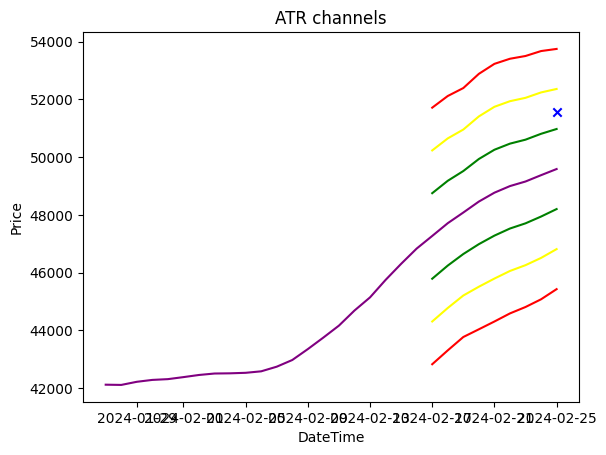

In [33]:
#Stop-i määramine
stop_price = 0

# Plotting multiple lines on the same chart
plt.plot(df_medium['dateTime'], df_medium['21EMA'], label='21EMA', color = 'purple')
plt.plot(df_medium['dateTime'], df_medium['ATR+1'], label='ATR+1',color = 'green')
plt.plot(df_medium['dateTime'], df_medium['ATR+2'], label='ATR+2',color = 'yellow')
plt.plot(df_medium['dateTime'], df_medium['ATR+3'], label='ATR+3',color = 'red')
plt.plot(df_medium['dateTime'], df_medium['ATR-1'], label='ATR-1',color = 'green')
plt.plot(df_medium['dateTime'], df_medium['ATR-2'], label='ATR-2',color = 'yellow')
plt.plot(df_medium['dateTime'], df_medium['ATR-3'], label='ATR-3',color = 'red')

# Show current price with an 'x'
last_price_x = df_medium['dateTime'].iloc[-1]
last_price_y = df_medium['Open Price'].iloc[-1]
plt.scatter(last_price_x, last_price_y, c='blue', marker='x', label='Last Price')

# Adding labels and title
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('ATR channels')
plt.yticks()

plt.show()

## Nüüd edasi siis stop-i ja entry määramine, aga selleks vaja veel teooriat

# SCREENER

In [34]:
#Ticker list

def get_top_cryptos_with_usdt():
    url = "https://api.binance.com/api/v3/exchangeInfo"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        symbols = data['symbols']
        top_cryptos_usdt = [symbol['symbol'] for symbol in symbols if 'USDT' in symbol['symbol']]
        return top_cryptos_usdt[:20]  # Adjust the limit based on your requirements
    else:
        print(f"Error: {response.status_code}")
        return None

# Run the function
top_cryptos_usdt = get_top_cryptos_with_usdt()

# Display the results
if top_cryptos_usdt:
    print("Top 20 trading pairs with USDT:")
    for crypto in top_cryptos_usdt:
        print(crypto)
else:
    print("Failed to retrieve data.")


Top 20 trading pairs with USDT:
BTCUSDT
ETHUSDT
BNBUSDT
BCCUSDT
NEOUSDT
LTCUSDT
QTUMUSDT
ADAUSDT
XRPUSDT
EOSUSDT
TUSDUSDT
IOTAUSDT
XLMUSDT
ONTUSDT
TRXUSDT
ETCUSDT
ICXUSDT
VENUSDT
NULSUSDT
VETUSDT


In [36]:
top_cryptos_usdt

['BTCUSDT',
 'ETHUSDT',
 'BNBUSDT',
 'BCCUSDT',
 'NEOUSDT',
 'LTCUSDT',
 'QTUMUSDT',
 'ADAUSDT',
 'XRPUSDT',
 'EOSUSDT',
 'TUSDUSDT',
 'IOTAUSDT',
 'XLMUSDT',
 'ONTUSDT',
 'TRXUSDT',
 'ETCUSDT',
 'ICXUSDT',
 'VENUSDT',
 'NULSUSDT',
 'VETUSDT']